## Anomaly detection in the CSC2 with the URF method
This code is adapted from Baron & Poznansy (2017). It uses the Unsupervised Random Forest Method to find anomalies in the Chandra Source Catalog. It uses Pandas and Scikit-learn. For more info see:
https://pandas.pydata.org
https://scikit-learn.org/stable/

In [1]:
%pylab inline
import numpy
#import sklearn
#from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from sklearn import ensemble
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Let us first read the data, and turn it into a pandas data frame.

In [2]:
from astropy.table import Table
table = Table.read('/Users/jmartine/science/chandra/classification/csc2_mastersrcs_sign_gt_5.fits')
#table = Table.read('csc2_mastersource_11Oct18_sign_gt_3.fits')
#table = Table.read('csc2_rafael.fits')
df = table.to_pandas()

/Users/jmartine/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: TableReplaceWarning: converted column 'var_intra_index_b' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jmartine/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: TableReplaceWarning: converted column 'var_intra_index_h' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jmartine/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: TableReplaceWarning: converted column 'var_intra_index_m' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jmartine/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: TableReplaceWarning: converted column 'var_intra_index_s' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jmartine/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: TableReplace

In [3]:
df

,name,ra,dec,gal_l,gal_b,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,...,acis_letg_num,hrc_num,hrc_hetg_num,hrc_letg_num,acis_time,acis_hetg_time,acis_letg_time,hrc_time,hrc_hetg_time,hrc_letg_time
0,b'2CXO J104656.5+123106 ',161.735821,12.518444,233.381751,57.415827,2.185927,1.399404,89.552700,10.373746,197.560059,...,0,0,0,0,1.521539e+05,NaN,NaN,NaN,NaN,NaN
1,b'2CXO J104704.0+123104 ',161.766983,12.517886,233.412024,57.441520,1.673347,1.295837,79.967689,9.536568,194.594603,...,0,0,0,0,1.521539e+05,NaN,NaN,NaN,NaN,NaN
2,b'2CXO J104707.0+124525 ',161.779498,12.756965,233.043059,57.575780,5.559328,3.135282,114.764209,6.337191,76.710501,...,0,0,0,0,1.521571e+05,NaN,NaN,NaN,NaN,NaN
3,b'2CXO J104715.4+123530 ',161.814270,12.591740,233.339272,57.519334,1.387049,0.980923,95.729200,7.312215,146.719716,...,0,0,0,0,1.521539e+05,NaN,NaN,NaN,NaN,NaN
4,b'2CXO J104718.2+122421 ',161.826012,12.405842,233.645493,57.432257,2.263883,1.710417,62.168717,9.998209,168.706398,...,0,0,0,0,1.521763e+05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24839,b'2CXO J033237.7-275212 ',53.157369,-27.870166,223.687429,-54.410992,0.711110,0.710884,167.623701,74.117837,27734.843828,...,0,0,0,0,5.580054e+06,NaN,NaN,NaN,NaN,NaN
24840,b'2CXO J033321.0-273911 ',53.337900,-27.653309,223.361087,-54.220440,0.731230,0.726422,144.720577,18.642039,1853.393378,...,0,0,0,0,2.400766e+05,NaN,NaN,NaN,NaN,NaN
24841,b'2CXO J033322.7-275523 ',53.344956,-27.923274,223.819382,-54.254830,0.754872,0.743085,123.373128,13.286264,704.241101,...,0,0,0,0,2.460370e+05,NaN,NaN,NaN,NaN,NaN
24842,b'2CXO J033318.9-273342 ',53.329156,-27.561765,223.204357,-54.213954,0.813195,0.735790,129.139216,19.494515,1306.981803,...,0,0,0,0,2.400766e+05,NaN,NaN,NaN,NaN,NaN


Now we create a new data frame that includes only certain values of the parameters. This is to exclude data artifacts, such as values of hardness ratios that are too close to 1.

In [4]:
#df1 = df[(1.0-np.absolute(df['hard_hs']) > 0.001) & (1.0-np.absolute(df['hard_ms']) > 0.001) & 
#        (1.0-np.absolute(df['hard_hm']) > 0.001) & (~pd.isnull(df['var_intra_prob_b'])) &
#        (df['var_intra_prob_b'] > 0.001) & (df['var_intra_prob_b'] < 0.999) & 
#         (~pd.isnull(df['hard_ms'])) & (~pd.isnull(df['flux_aper_m'])) &
#        (~pd.isnull(df['flux_aper_m'])) & (~pd.isnull(df['powlaw_nh'])) &
#        (~pd.isnull(df['bb_nh'])) & (~pd.isnull(df['brems_nh'])) & 
#         (~pd.isnull(df['var_inter_hard_prob_hm'])) & (~pd.isnull(df['var_inter_hard_prob_hs'])) &
#        (~pd.isnull(df['var_inter_hard_prob_ms'])) & 
#         (1.0-np.absolute(df['var_inter_hard_prob_hm']) > 0.001) &
#        (1.0-np.absolute(df['var_inter_hard_prob_hs']) > 0.001) &
#        (1.0-np.absolute(df['var_inter_hard_prob_ms']) > 0.001) &
#        (df['var_inter_hard_prob_hm'] > 0.01) & (df['var_inter_hard_prob_hs'] > 0.01) &
#        (df['var_inter_hard_prob_ms'] > 0.01)]

#df1 = df[(1.0-np.absolute(df['hard_hs']) > 0.01) & (1.0-np.absolute(df['hard_ms']) > 0.01) & 
#        (1.0-np.absolute(df['hard_hm']) > 0.01) & (df['powlaw_gamma'] < 9.999) &
#        (np.absolute(13.58-df['brems_kt']) > 0.0001) & (np.absolute(54.32-df['brems_kt']) > 0.002) &
#        (df['brems_kt'] < 99.9) & (~pd.isnull(df['var_inter_hard_sigma_hm'])) &
#        (~pd.isnull(df['var_inter_hard_sigma_hs'])) & (~pd.isnull(df['var_inter_hard_sigma_ms']))]

#df1 = df[(np.absolute(13.58-df['brems_kt']) > 0.0001) & (np.absolute(54.32-df['brems_kt']) > 0.002) &
#        (df['brems_kt'] < 99.9)]

df1 = df

In [15]:
len(np.isnan(df1['bb_kt'].values)[np.isnan(df1['bb_kt'].values)==False])

7881

/Users/jmartine/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmartine/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  2., 157., 139., 114., 127.,  86., 111., 102., 106., 115., 110.,
        104., 109., 120., 138.,  99., 102., 103.,  96., 109., 121., 115.,
         96., 107., 111., 107., 118., 127., 115., 115., 133., 137., 126.,
        115., 120., 114.,  91., 128.,  96.,  98.,  94., 107., 107.,  72.,
         87.,  82.,  89.,  84.,  66.,  72.,  58.,  64.,  67.,  65.,  52.,
         51.,  55.,  54.,  49.,  57.,  35.,  38.,  40.,  35.,  42.,  31.,
         27.,  30.,  49.,  17.,  33.,  28.,  21.,  25.,  38.,  25.,  25.,
         23.,  25.,  22.,  29.,  25.,  21.,  23.,  15.,  20.,  15.,  11.,
         20.,  14.,  22.,  14.,  14.,  12.,  13.,  15.,  11.,  12.,   7.,
         12.,   9.,  11.,  18.,   9.,   9.,   6.,  13.,   9.,  14.,   8.,
         16.,   6.,   9.,   7.,  13.,   5.,   8.,   9.,   6.,   9.,   7.,
          7., 247.,   2.,   1.,   0.,   1.,   5.,   0.,   5.,   4.,   3.,
          4.,   0.,   1.,   2.,   0.,   4.,   6.,   1.,   2.,   4.,   3.,
          1.,   1.,   1.,   3.,   2., 

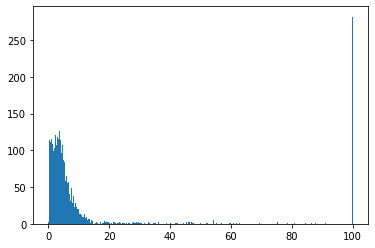

In [4]:
plt.hist(df1['brems_kt'].values,bins=900)
#plt.xlim(0,30)

In [7]:
np.sort(df1['brems_kt'].values)

array([0.00080284, 0.104638  , 0.115842  , ...,        nan,        nan,
              nan])

In [6]:
#df1 = df[(1.0-np.absolute(df['hard_hs']) > 0.001) & (1.0-np.absolute(df['hard_ms']) > 0.001) & 
#        (1.0-np.absolute(df['hard_hm']) > 0.001) & (~pd.isnull(df['var_intra_prob_b'])) &
#        (df['var_intra_prob_b'] > 0.001) & (df['var_intra_prob_b'] < 0.999) & (~pd.isnull(df['flux_aper_b'])) &
#        (~pd.isnull(df['flux_aper_m'])) & (~pd.isnull(df['flux_aper_s'])) & (~pd.isnull(df['hard_ms'])) &
#        (df['flux_aper_b'] > 0.0) & (df['flux_aper_m'] > 0.0) & (df['flux_aper_s'] > 0.0) & (df['likelihood'] < 1E50) & 
#        (df['significance'] > 3) & (~pd.isnull(df['var_inter_hard_prob_hs'])) & (~pd.isnull(df['var_inter_hard_prob_hm'])) 
#         & (~pd.isnull(df['var_inter_hard_prob_ms'])) & (~pd.isnull(df['bb_kt'])) & (~pd.isnull(df['powlaw_nh']))]

In [8]:
df1.columns.values

array(['name', 'ra', 'dec', 'gal_l', 'gal_b', 'err_ellipse_r0',
       'err_ellipse_r1', 'err_ellipse_ang', 'significance', 'likelihood',
       'likelihood_class', 'conf_flag', 'dither_warning_flag',
       'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag',
       'var_flag', 'var_inter_hard_flag', 'man_add_flag', 'man_inc_flag',
       'man_match_flag', 'man_pos_flag', 'man_reg_flag', 'major_axis_b',
       'major_axis_lolim_b', 'major_axis_hilim_b', 'minor_axis_b',
       'minor_axis_lolim_b', 'minor_axis_hilim_b', 'pos_angle_b',
       'pos_angle_lolim_b', 'pos_angle_hilim_b', 'src_area_b',
       'major_axis_h', 'major_axis_lolim_h', 'major_axis_hilim_h',
       'minor_axis_h', 'minor_axis_lolim_h', 'minor_axis_hilim_h',
       'pos_angle_h', 'pos_angle_lolim_h', 'pos_angle_hilim_h',
       'src_area_h', 'major_axis_m', 'major_axis_lolim_m',
       'major_axis_hilim_m', 'minor_axis_m', 'minor_axis_lolim_m',
       'minor_axis_hilim_m', 'pos_angle_m', 'pos_angle_lolim

Next we can plot some histrograms of the properties.

In [9]:
#plt.hist(np.log10(~np.isnan(df1['src_area_b'].values)))
#plt.hist(((df1['var_inter_hard_prob_hs'][~np.isnan(df1['var_inter_hard_prob_hs'].values)])),bins=40)
#plt.hist(np.log10(df1['brems_kt']),bins=40)

(array([130., 242., 197., 188., 187., 210., 186., 211., 210., 183., 179.,
        223., 184., 191., 203., 222., 215., 246., 216., 203., 195., 186.,
        175., 190., 134., 156., 143., 117., 114., 117.,  91.,  95., 106.,
         70.,  69.,  73.,  53.,  48.,  66.,  52.,  43.,  56.,  42.,  45.,
         47.,  44.,  35.,  30.,  23.,  32.,  35.,  24.,  23.,  22.,  16.,
         20.,  25.,  16.,  17.,  18.,  22.,  21.,  13.,  17.,  13.,  13.,
         15., 256.,   3.,   1.,   6.,   4.,   5.,   7.,   1.,   2.,   7.,
          5.,   5.,   4.,   2.,   5.,   1.,   1.,   1.,   3.,   4.,   1.,
          3.,   5.,   2.,   4.,   5.,   5.,   3.,   7.,   5.,   2.,   4.,
          5.,   3.,   1.,   2.,   1.,   2.,   1.,   2.,   7.,   2.,   2.,
          2.,   0.,   3.,   3.,   4.,   3.,   1.,   2.,   2.,   1.,   1.,
          3.,   2.,   1.,   2.,   1.,   0.,   0.,   2.,   0.,   1.,   1.,
          2.,   1.,   0.,   2.,   0.,   2.,   1.,   2.,   2.,   1.,   1.,
          1.,   2.,   3.,   2.,   0., 

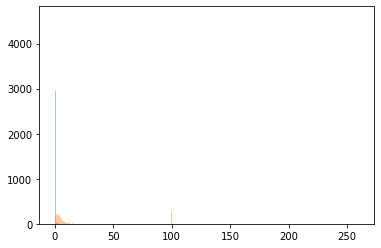

In [7]:
#plt.hist(df1['hard_hs'].values,alpha=0.4)
#plt.hist(df1['hard_ms'].values,alpha=0.4)
#plt.hist(df1['hard_hm'].values,alpha=0.4)
#plt.hist(df1['hard_hs'].values,alpha=0.4)
plt.hist(df1['bb_kt'].values,alpha=0.4,bins=500)
plt.hist(df1['brems_kt'].values,alpha=0.4,bins=500)

The next part is important. This is where we create the 'X' array, that contains all the properties that we will actually use. Those values have already been filtered for artifacts. We also create IDs for each of the objects.

In [9]:
# Create an array with the features
#X = [np.log10(df1['significance'].values),np.log10(df1['flux_aper_b'].values),
#     np.log10(df1['flux_aper_m'].values), np.log10(df1['flux_aper_s'].values), 
#     df1['hard_hs'].values,df1['hard_ms'].values,df1['hard_hm'].values,df1['var_intra_prob_b'].values,
#    df1['ks_intra_prob_b'].values,df1['kp_intra_prob_b'].values,df1['var_inter_prob_b'].values,
#    df1['brems_kt'].values]

#X = [df1['hard_hs'].values,df1['hard_ms'].values,df1['hard_hm'].values, df1['var_intra_prob_b'].values, 
#     1.0-df1['var_inter_hard_prob_hs'].values, 1.0-df1['var_inter_hard_prob_ms'].values, 
#     1.0-df1['var_inter_hard_prob_hm'].values,np.log10(df1['bb_kt'].values),np.log10(df1['powlaw_nh'].values)]

X = [df1['hard_hs'].values, df1['hard_ms'].values, df1['hard_hm'].values, 
     (df1['powlaw_gamma'].values), np.log10(df1['powlaw_nh'].values), 
    np.log10(df1['bb_kt'].values), np.log10(df1['bb_nh'].values), 
     np.log10(df1['brems_kt'].values), np.log10(df1['brems_norm'].values),
    df1['var_inter_hard_sigma_hs'].values, df1['var_inter_hard_sigma_hm'].values,
    df1['var_inter_hard_sigma_ms'].values]

#X = [df1['hard_hs'].values,df1['hard_ms'].values,df1['hard_hm'].values]

X = np.array(X)
X = X.T
obj_ids = np.arange(len(X))
#X = X[0:15000]

(array([4.0000e+00, 1.0000e+00, 6.3000e+01, 2.2600e+02, 1.8700e+02,
        2.3000e+02, 2.7900e+02, 3.3200e+02, 4.9300e+02, 7.1600e+02,
        1.8183e+04, 1.3890e+03, 1.1870e+03, 6.8700e+02, 3.9900e+02,
        2.4100e+02, 1.0500e+02, 4.5000e+01, 2.1000e+01, 1.5000e+01,
        7.0000e+00, 9.0000e+00, 7.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.9999392 , -0.93163671, -0.86333422, -0.79503172, -0.72672923,
        -0.65842674, -0.59012425, -0.52182175, -0.45351926, -0.38521677,
        -0.31691428, -0.24861178, -0.18030929, -0.1120068 , -0.04370431,
         0.02459819,  0.09290068,  0.16120317,  0.22950567,  0.29780816,
         0.36611065,  0.43

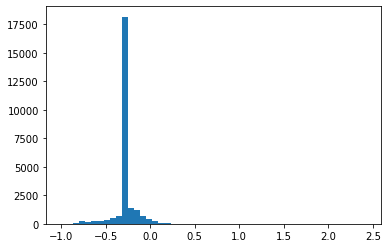

In [14]:
plt.hist(X[:,5],bins=50)

In [13]:
# Data imputation
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp.fit(X)
#X = imp.transform(X)

Let's look at how many objects we have, and how many properties for each, by measurint the dimensions of 'X'.

In [8]:
np.shape(X)

(24844, 12)

In [9]:
len(X[0])

12

Now we create the synthetic data by sampling the marginal distributions of 'X'.

In [10]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(X)

Let's plot some to the features (catalog properties) for both the real and synthetic data.

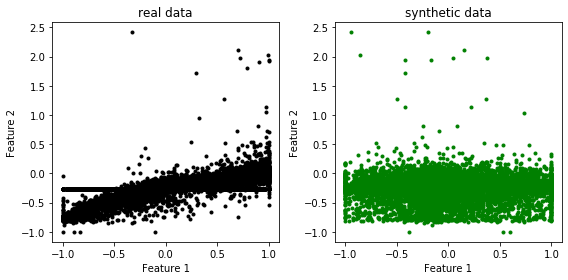

In [11]:
plt.rcParams['figure.figsize'] = 8, 4

plt.subplot(1, 2, 1)
plt.title("real data")
plt.plot(X[:, 0], X[:, 5], "ok", markersize=3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.title("synthetic data")
plt.plot(X_syn[:, 0], X_syn[:, 5], "og", markersize=3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()

And now let's make sure that the marginal distributions actually look the same for both real and synthetic data.

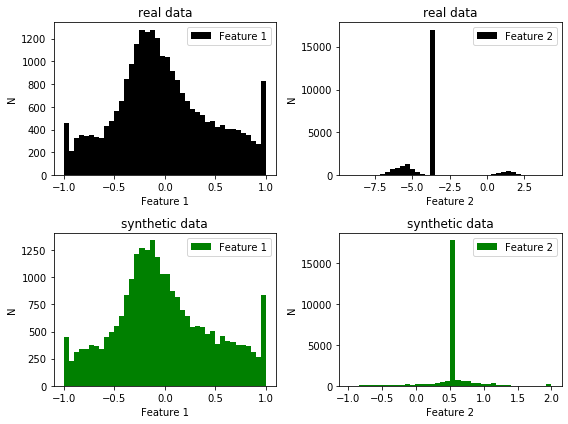

In [25]:
# Now lets plot the marginal distributions of the *'real'* and *'synthetic'* data and make sure 
# that they match for a given feature:

plt.rcParams['figure.figsize'] = 8, 6

plt.subplot(2, 2, 1)
plt.title("real data")
tmp = plt.hist(X[:,0], bins=40, color="k", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")

plt.subplot(2, 2, 2)
plt.title("real data")
tmp = plt.hist(X[:, 6], bins=40, color="k", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")

plt.subplot(2, 2, 3)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 0], bins=40, color="g", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")

plt.subplot(2, 2, 4)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 7], bins=40, color="g", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")

plt.tight_layout()

Here's another important step. Let's build the random forest classifier that leanrs to distinguish between real and synthetic data. This is an essential step before we can do the anomaly analysis.

In [16]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(X, X_syn)
# declare an RF
N_TRAIN = 50 # number of trees in the forest
rand_f = ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                 max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=True)

rand_f.fit(X_total, Y_total)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-06, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=True)

In [19]:
y_pred = rand_f.predict(X_total)
print(y_pred)
print(rand_f.score(X_total,Y_total))

[1. 1. 1. ... 2. 2. 2.]
1.0


In [17]:
importances = rand_f.feature_importances_
std = np.std([rand_f.feature_importances_ for tree in rand_f.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#rand_f.score(X_total[50000:],Y_total[50000:])

Feature ranking:
1. feature 0 (0.126913)
2. feature 3 (0.116250)
3. feature 5 (0.105236)
4. feature 7 (0.104017)
5. feature 4 (0.092844)
6. feature 6 (0.088891)
7. feature 1 (0.088852)
8. feature 2 (0.088496)
9. feature 8 (0.085790)
10. feature 9 (0.037660)
11. feature 10 (0.034006)
12. feature 11 (0.031043)


In [18]:
len(X_total)

49688

Now we build the similarity matrix by examining, for each pair of objects, how many times they fall in the same leaf of a tree when propagated through the forest that we have trained above. Because this a pair-wise operation, it is the most computationally expensive part of the code. Below are two ways to do it. The first cell is the standard way from the original paper. The cell after is a modified version from Crake & Martinez-Galarza. The second one should be more efficient.

In [ ]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, X)
dis_mat = 1 - sim_mat

In [26]:
print(np.shape(dis_mat))

(30115, 30115)


In [19]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    leaf_pop=np.zeros((np.max(apply_mat[:,:]+1),N_TRAIN))
    #creates an array of each leaf population for all trees in RF
    for i in range(len(X)):
        for j in range(N_TRAIN):
            if apply_mat[i,j]!= -1:
                leaf_pop[apply_mat[i,j],j]+=1

    Normalization=np.sum(leaf_pop,axis=0)

    #creates the similarity matrix by using the leaf populations
    #rather then pair matching each light curve
    sim_vec=np.zeros(len(X))
    for i in range(len(X)):
        for j in range(N_TRAIN):
            sim_vec[i]+=(leaf_pop[(apply_mat[i,j]),j]) #adds
    #normalization here '/Normalization[j]'
    sim_vec/= float(len(sim_vec-1))*N_TRAIN
    return sim_vec


sim_mat = build_similarity_matrix(rand_f, X)
dis_mat = 1 - sim_mat
sum_vec = dis_mat

In [20]:
print(np.shape(dis_mat))

(24844,)


We now plot the histogram of weirdness. Weirdness is obtained from comparing each object to all others using the similarity matrix, as calculated above.

Text(0.5, 0, 'weirdness score')

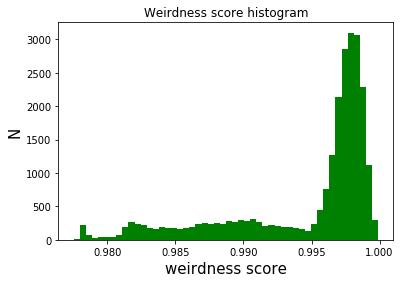

In [21]:
#sum_vec = numpy.sum(dis_mat, axis=1)
#sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(dis_mat, bins=50, color='g')
plt.ylabel("N",size=15)
plt.xlabel("weirdness score",size=15)
#plt.savefig('Weirdness_CSC2.png',dpi=300,box_inches='tight')

Next we plot some of the fitures and hightlight the top 100 weirdest objects.

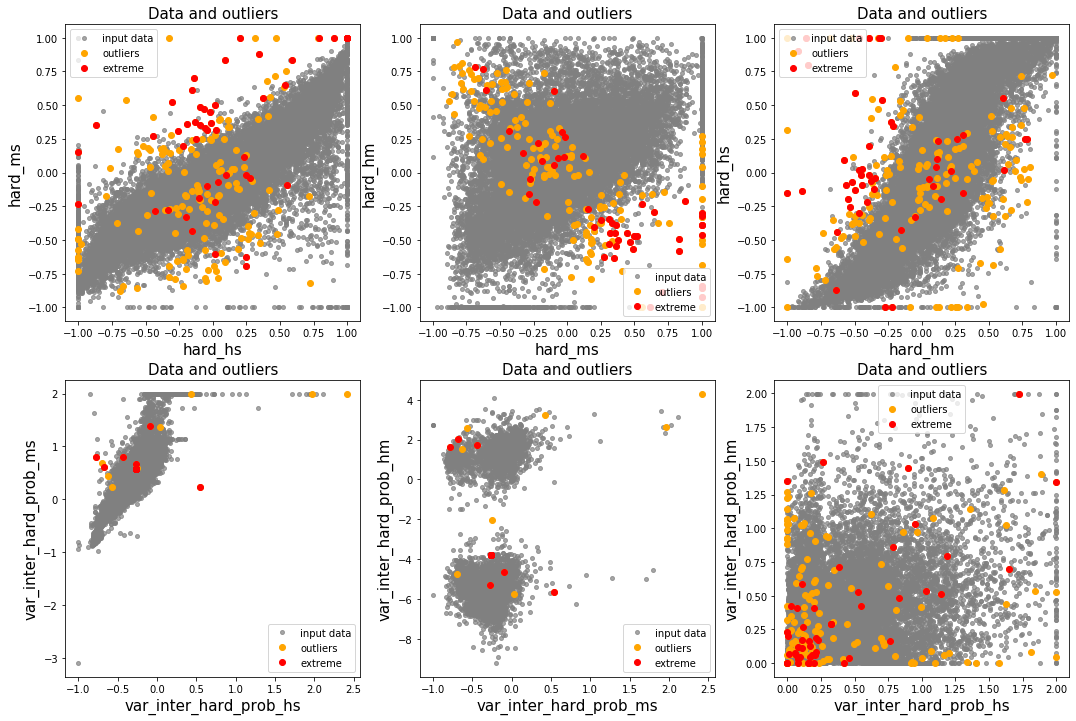

In [22]:
#obj_ids_most = [4314,9951,4914,4048,1162,8600,7138,3348,8862,9733,7835,10023,3368,3556,5234]
N_outliers = 200
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]
obs_ids_outliers_most = obj_ids[numpy.argsort(sum_vec)][::-1][:50]

plt.rcParams['figure.figsize'] = 18, 12
plt.subplots(2,3)
plt.subplot(2,3,1)
plt.title("Data and outliers",size=15)
plt.plot(X[:,0], X[:,1], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 0], X[obj_ids_outliers, 1], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 0], X[obs_ids_outliers_most, 1], "om", label="extreme", markersize=6,color='red')
plt.xlabel("hard_hs",size=15)
plt.ylabel("hard_ms",size=15)	
plt.legend(loc="best")
plt.subplot(2,3,2)
plt.title("Data and outliers",size=15)
plt.plot(X[:,1], X[:,2], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 1], X[obj_ids_outliers, 2], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 1], X[obs_ids_outliers_most, 2], "om", label="extreme", markersize=6,color='red')
plt.xlabel("hard_ms",size=15)
plt.ylabel("hard_hm",size=15)	
plt.legend(loc="best")
plt.subplot(2,3,3)
plt.title("Data and outliers",size=15)
plt.plot(X[:,2], X[:,0], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 2], X[obj_ids_outliers, 0], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 2], X[obs_ids_outliers_most, 0], "om", label="extreme", markersize=6,color='red')
plt.xlabel("hard_hm",size=15)
plt.ylabel("hard_hs",size=15)	
plt.legend(loc="best")
plt.subplot(2,3,4)
plt.title("Data and outliers",size=15)
plt.plot(X[:,5], X[:,7], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 5], X[obj_ids_outliers, 7], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 5], X[obs_ids_outliers_most, 7], "om", label="extreme", markersize=6,color='red')
plt.xlabel("var_inter_hard_prob_hs",size=15)
plt.ylabel("var_inter_hard_prob_ms",size=15)	
plt.legend(loc="best")
plt.subplot(2,3,5)
plt.title("Data and outliers",size=15)
plt.plot(X[:,5], X[:,6], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 5], X[obj_ids_outliers, 6], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 5], X[obs_ids_outliers_most, 6], "om", label="extreme", markersize=6,color='red')
plt.xlabel("var_inter_hard_prob_ms",size=15)
plt.ylabel("var_inter_hard_prob_hm",size=15)	
plt.legend(loc="best")
plt.subplot(2,3,6)
plt.title("Data and outliers",size=15)
plt.plot(X[:,9], X[:,10], "ok", label="input data", markersize=4,color='gray',alpha=0.7)
plt.plot(X[obj_ids_outliers, 9], X[obj_ids_outliers, 10], "om", label="outliers", markersize=6,color='orange')
plt.plot(X[obs_ids_outliers_most, 9], X[obs_ids_outliers_most, 10], "om", label="extreme", markersize=6,color='red')
plt.xlabel("var_inter_hard_prob_hs",size=15)
plt.ylabel("var_inter_hard_prob_hm",size=15)	
plt.legend(loc="best")
#plt.savefig('outliers_hardness_30trees_with_spec_var.png',dpi=300,box_inches='tight')

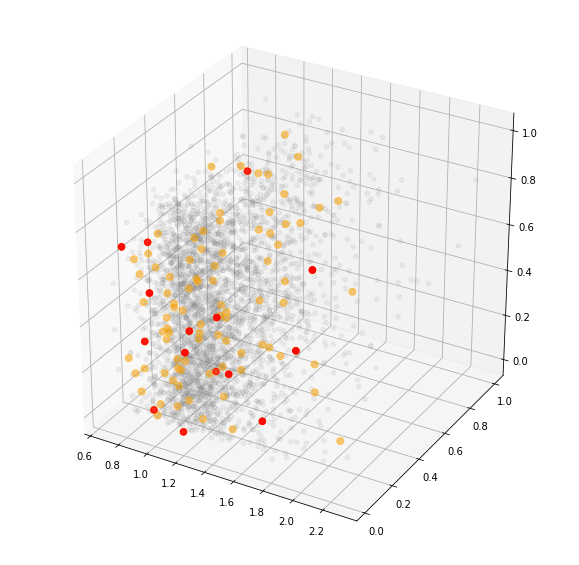

In [65]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,7], X[:,5], X[:,6],"ok", label="input data",color='gray',alpha=0.1)
ax.scatter(X[obj_ids_outliers, 7], X[obj_ids_outliers, 5], X[obj_ids_outliers, 6], label="outliers",color='orange',s=50,alpha=0.5)
ax.scatter(X[obs_ids_outliers_most, 7], X[obs_ids_outliers_most, 5], X[obs_ids_outliers_most, 6], label="outliers",color='red',s=40)
ax.scatter(X[obs_ids_outliers_most, 7], X[obs_ids_outliers_most, 5], X[obs_ids_outliers_most, 6], label="outliers",color='red',s=40)
ax.scatter(X[obs_ids_outliers_most, 7], X[obs_ids_outliers_most, 5], X[obs_ids_outliers_most, 6], label="outliers",color='red',s=40)

In [66]:
print (np.shape(X))

(3476, 16)


The following cell is a wrap up of the code above. Basically we repeat the process 20 times and get an average of the weirdness over the 20 runs. This is to reduce variance in the results, since the random forest is after all a stochastic process that will give slightly diffrent results each time.

In [31]:
obs_ids_outliers_all = []
obs_ids_outliers1_all = []
scores_more = []
scores_less = []
#start=time.time()
Weirdness=np.zeros((len(X),2))

for i in range(20):
    X_syn = return_synthetic_data(X)
    X_total, Y_total = merge_work_and_synthetic_samples(X, X_syn)
    # declare an RF
    N_TRAIN = 50 # number of trees in the forest
    rand_f = sklearn.ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                 max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=True)
    rand_f.fit(X_total, Y_total)
    sim_mat = build_similarity_matrix(rand_f, X)
    dis_mat = 1 - sim_mat
    sum_vec = dis_mat
    N_outliers=100    
    sum_vec_outliers = np.sort(sum_vec)[::-1][:N_outliers]
    scores_more.append(sum_vec_outliers)
    obs_ids_outliers_all.append(obj_ids[np.argsort(sum_vec)][::-1][:N_outliers])
    sum_vec_outliers1 = np.sort(sum_vec)[:N_outliers]
    scores_less.append(sum_vec_outliers1)
    obs_ids_outliers1_all.append(obj_ids[np.argsort(sum_vec)][:N_outliers])
    for j in range(len(X)):
        Weirdness[j][0]+=dis_mat[j]
        if i==19:
            Weirdness[j][0]/=20
        Weirdness[j][1]=int(j)

In [32]:
Weirdness

array([[9.93825018e-01, 0.00000000e+00],
       [9.68727240e-01, 1.00000000e+00],
       [9.78330845e-01, 2.00000000e+00],
       ...,
       [9.88674436e-01, 5.48900000e+03],
       [9.54588310e-01, 5.49000000e+03],
       [9.57088674e-01, 5.49100000e+03]])

In [33]:
#df1.reindex(Weirdness[:,1].astype(int))
df1['weirdness'] = Weirdness[:,0].tolist()

/Users/jmartine/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Finally we print the list ob objects ranked by weirdness.

In [34]:
df1.sort_values(by=['weirdness'])

,name,ra,dec,gal_l,gal_b,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,...,hrc_num,hrc_hetg_num,hrc_letg_num,acis_time,acis_hetg_time,acis_letg_time,hrc_time,hrc_hetg_time,hrc_letg_time,weirdness
13984,2CXO J100016.2+015104,150.067901,1.851273,237.170053,41.873593,0.322410,0.307595,81.855977,11.134656,796.954701,...,1.0,0.0,0.0,2.884918e+05,NaN,NaN,7.929888e+04,NaN,NaN,0.941087
7413,2CXO J100527.2-074204,151.363713,-7.701317,247.812973,36.833137,0.295086,0.292724,167.299850,44.523277,10559.717503,...,0.0,0.0,0.0,1.137569e+06,NaN,NaN,NaN,NaN,NaN,0.942809
10973,2CXO J134147.6+261319,205.448396,26.222179,31.180365,78.719314,0.750675,0.424826,11.407289,17.818689,999.610405,...,0.0,0.0,0.0,9.876868e+04,NaN,NaN,NaN,NaN,NaN,0.943068
3563,2CXO J065758.8-555004,104.495241,-55.834677,265.886123,-21.285983,0.313180,0.312198,43.670631,30.311861,4589.574447,...,0.0,0.0,0.0,3.987095e+05,NaN,NaN,NaN,NaN,NaN,0.943341
14540,2CXO J033208.6-274734,53.036092,-27.792983,223.528805,-54.505633,0.290326,0.290212,10.320937,191.129920,227818.230914,...,0.0,0.0,0.0,5.807534e+06,NaN,NaN,NaN,NaN,NaN,0.943457
13519,2CXO J132910.3+472212,202.293046,47.370045,105.342524,68.448761,1.205956,0.821368,90.948773,23.301594,976.980083,...,0.0,0.0,0.0,3.979343e+05,NaN,NaN,NaN,NaN,NaN,0.943897
13421,2CXO J140350.4+542413,210.960405,54.403779,101.943711,59.675063,0.304508,0.296698,64.400890,17.452558,1564.101060,...,0.0,0.0,0.0,5.012400e+05,NaN,NaN,NaN,NaN,NaN,0.943949
9624,2CXO J010138.9-214927,15.412401,-21.824393,147.129521,-84.210083,0.302750,0.300997,133.759495,20.126059,2138.923306,...,0.0,0.0,0.0,3.354690e+05,NaN,NaN,NaN,NaN,NaN,0.944336
13236,2CXO J133658.7-294336,204.244719,-29.726669,314.608466,32.110410,0.490970,0.354921,15.426078,23.759595,1767.675888,...,1.0,0.0,0.0,2.251541e+05,NaN,NaN,2.001773e+04,NaN,NaN,0.944421
7061,2CXO J155614.5+662319,239.060503,66.388754,100.172185,41.646400,0.292288,0.291673,8.594243,20.204067,2283.848618,...,0.0,0.0,0.0,4.194459e+05,NaN,NaN,NaN,NaN,NaN,0.944425


In [135]:
#df1

In [35]:
df1.to_csv('weirdness_test5.csv')

In [ ]:
# Sorts objects by average weirdness over all repeats.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Weirdness=Weirdness[Weirdness[:,0].argsort()]
print(Weirdness)
final_ids=(Weirdness[:,1])
print(shape(Weirdness))

In [ ]:
final_ids[-10:]

In [ ]:
for ite in final_ids[-50:]:
    ito = int(ite)
    print(df1['name'].values[ito],df1['ra'].values[ito],df1['dec'].values[ito],df1['hard_hm'].values[ito],
          df1['hard_ms'].values[ito],df1['var_inter_hard_prob_hs'].values[ito],df1['var_inter_hard_prob_ms'].values[ito],
         df1['var_inter_hard_prob_hm'].values[ito])
#ito = 53168 #int(final_ids[it])
#print(ito)
#print(df1['name'].values[ito])
#print(df1['hard_hm'].values[ito],df1['hard_ms'].values[ito])
#print(df1['ra'].values[ito],df1['dec'].values[ito])

In [ ]:
df1['hard_hs'].values[417]